# Forest Cover Type Prediction

Competition accessible [here](https://www.kaggle.com/c/forest-cover-type-prediction/)

# Exploration

**Loading**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

**First look at the data**

In [3]:
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
Id                                    15120 non-null int64
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil_T

In [5]:
train.nunique()

Id                                    15120
Elevation                              1665
Aspect                                  361
Slope                                    52
Horizontal_Distance_To_Hydrology        400
Vertical_Distance_To_Hydrology          423
Horizontal_Distance_To_Roadways        3250
Hillshade_9am                           176
Hillshade_Noon                          141
Hillshade_3pm                           247
Horizontal_Distance_To_Fire_Points     2710
Wilderness_Area1                          2
Wilderness_Area2                          2
Wilderness_Area3                          2
Wilderness_Area4                          2
Soil_Type1                                2
Soil_Type2                                2
Soil_Type3                                2
Soil_Type4                                2
Soil_Type5                                2
Soil_Type6                                2
Soil_Type7                                1
Soil_Type8                      

**Exploration**

Let's look at the distribution of numerical features

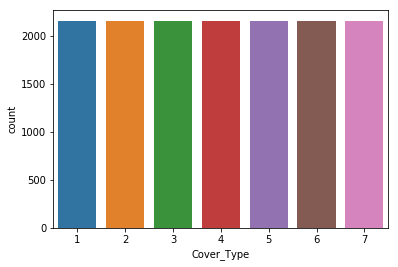

In [79]:
sns.countplot(train['Cover_Type'])

The data is distributed correctly in terms of Cover_Type. Good! We will probably not need any resampling to augment the data.

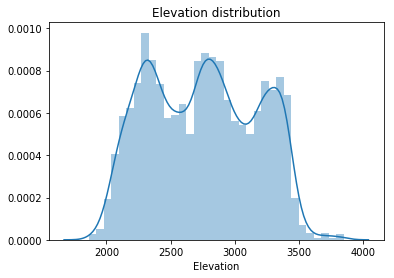

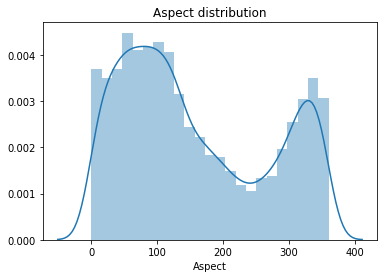

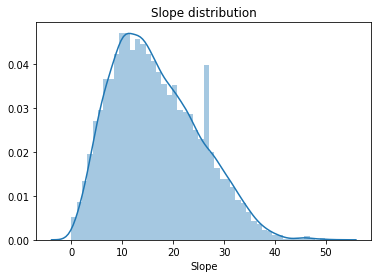

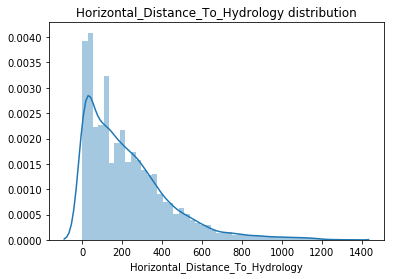

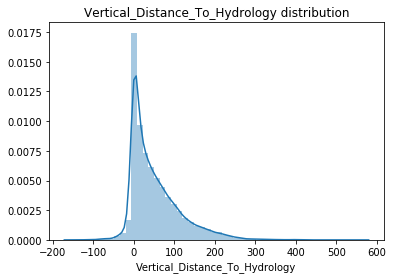

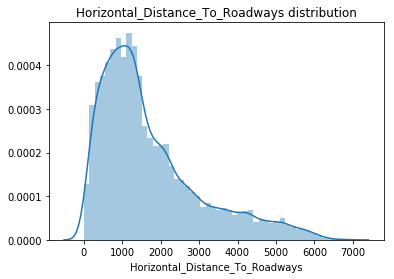

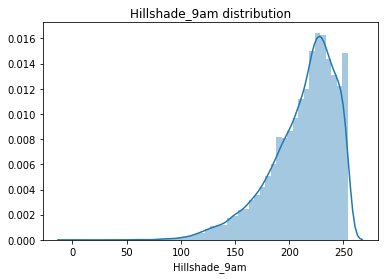

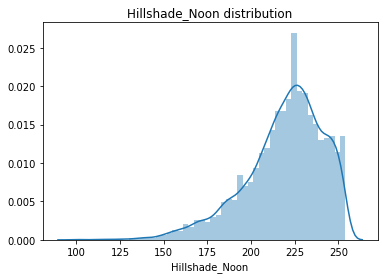

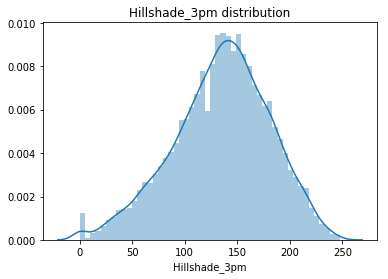

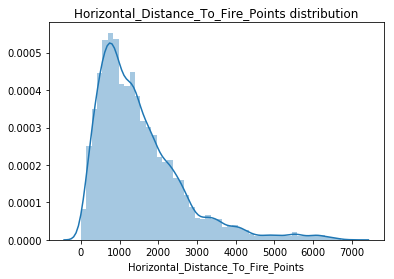

In [30]:
cat_names=['Elevation','Aspect','Slope',
           'Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
           'Horizontal_Distance_To_Roadways',
           'Hillshade_9am','Hillshade_Noon','Hillshade_3pm',
           'Horizontal_Distance_To_Fire_Points']

for name in cat_names:
    sns.distplot(train[name])
    plt.title(name + ' distribution')
    plt.show()

<Figure size 720x720 with 0 Axes>

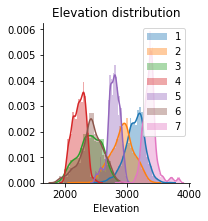

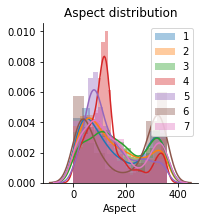

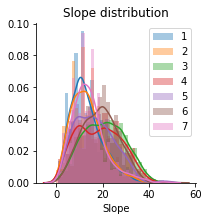

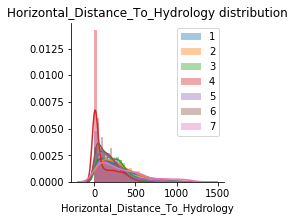

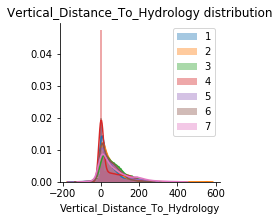

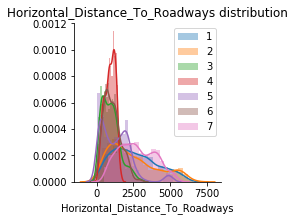

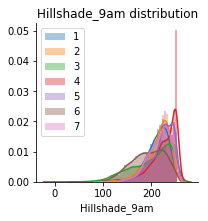

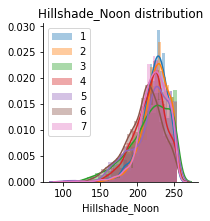

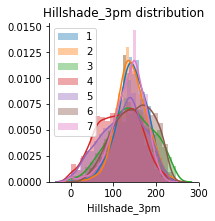

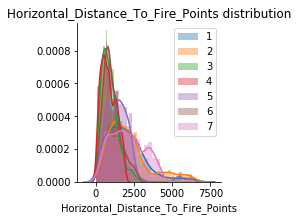

In [25]:
cat_names=['Elevation','Aspect','Slope',
           'Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
           'Horizontal_Distance_To_Roadways',
           'Hillshade_9am','Hillshade_Noon','Hillshade_3pm',
           'Horizontal_Distance_To_Fire_Points']

plt.figure(figsize=(10,10))

for name in cat_names:
    g = sns.FacetGrid(train, hue="Cover_Type")
    g = g.map(sns.distplot, name)
    plt.title(name + ' distribution')
    plt.legend()

We need to correct the distribution of:
- 'Aspect' : skewed left and right
- 'Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways' not skewed in the left
- 'Hillshade_9am','Hillshade_Noon' skewed on the right

Aspect transformation

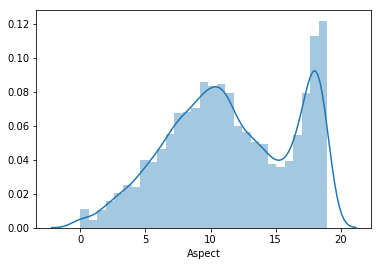

In [46]:
sns.distplot(train['Aspect'].apply(lambda x:np.sqrt(x)))

Slope transformation

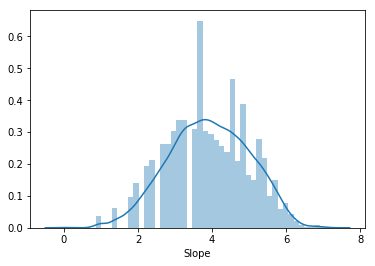

In [53]:
skew=['Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways' ]

i = 'Slope'

sns.distplot(train[i].apply(lambda x:np.sqrt(x)))
#sns.distplot(train[i].apply(lambda x:np.log(x)))
#sns.distplot(boxcox(train[i])[0])


((array([-3.91160696, -3.69194278, -3.57159081, ...,  3.57159081,
          3.69194278,  3.91160696]),
  array([0.        , 0.        , 0.        , ..., 7.        , 7.07106781,
         7.21110255])),
 (1.0748753474578356, 3.9166666836211834, 0.9971883818446273))

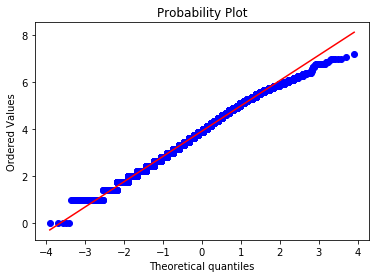

In [54]:
from scipy import stats
fig,axes = plt.subplots(ncols=1,nrows=1)
stats.probplot(train[i].apply(lambda x:np.sqrt(x)), dist='norm', fit=True, plot=axes)

It looks like a normal distribution now! Good! We do the other ones in the same way

Vertical_Distance_To_Hydrology

We remove the outliers under 100 and translate the data to apply transformations

In [86]:
len(train[train[i]==-100][i])

0

In [6]:
def train_rem_outliers(train):
    train = train[train['Vertical_Distance_To_Hydrology']>-100]
    return train

In [219]:
train = train_rem_outliers(train)

We translate of 100 and apply the sqrt to get a somewhat normal distribution

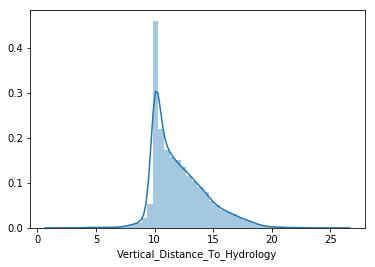

In [124]:
skew=['Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways' ]

i = 'Vertical_Distance_To_Hydrology'
data = train[i]

#sns.distplot(data)
sns.distplot(data.apply(lambda x:np.sqrt(x+100)))
#sns.distplot(data.apply(lambda x:np.log(x)))
#sns.distplot(boxcox(data)[0])

((array([-3.91143123, -3.69175773, -3.57140024, ...,  3.57140024,
          3.69175773,  3.91143123]),
  array([ 1.73205081,  2.23606798,  3.31662479, ..., 25.43619468,
         25.43619468, 25.57342371])),
 (2.2054391523491463, 12.079447620208018, 0.9592083279433216))

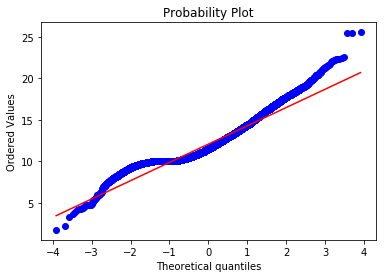

In [125]:
from scipy import stats
data = data.apply(lambda x:np.sqrt(x+100))
fig,axes = plt.subplots(ncols=1,nrows=1)
stats.probplot(data, dist='norm', fit=True, plot=axes)

'Hillshade_9am','Hillshade_Noon'

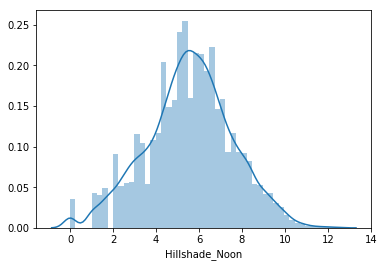

In [214]:
skew=['Hillshade_9am','Hillshade_Noon']

i = 'Hillshade_Noon'
data = train[i]

#sns.distplot(data)
sns.distplot(data.apply(lambda x:np.sqrt(-x+data.max())))
#sns.distplot(data.apply(lambda x:np.log(x)))
#sns.distplot(boxcox(data)[0])

((array([-3.91160696, -3.69194278, -3.57159081, ...,  3.57159081,
          3.69194278,  3.91160696]),
  array([ 0.       ,  0.       ,  0.       , ..., 12.4498996, 12.4498996,
         12.4498996])),
 (2.0176245462018576, 5.563541930999394, 0.9984567029401265))

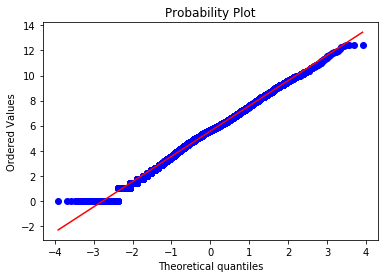

In [215]:
from scipy import stats
data = data.apply(lambda x:np.sqrt(-x+data.max()))
fig,axes = plt.subplots(ncols=1,nrows=1)
stats.probplot(data, dist='norm', fit=True, plot=axes)

In [7]:
def test_edit_dist(train):
    train['Aspect']=train['Aspect'].apply(lambda x:np.sqrt(x))
    train['Slope']=train['Slope'].apply(lambda x:np.sqrt(x)) 
    train['Horizontal_Distance_To_Hydrology']=train['Horizontal_Distance_To_Hydrology'].apply(lambda x:np.sqrt(x))     
    train['Vertical_Distance_To_Hydrology']=train['Vertical_Distance_To_Hydrology'].apply(lambda x:np.sqrt(x+100))     
    train['Horizontal_Distance_To_Roadways']=train['Horizontal_Distance_To_Roadways'].apply(lambda x:np.sqrt(x)) 
    train['Hillshade_9am']=train['Hillshade_9am'].apply(lambda x:np.sqrt(-x+train['Hillshade_9am'].max()))
    train['Hillshade_Noon']=train['Hillshade_Noon'].apply(lambda x:np.sqrt(-x+train['Hillshade_Noon'].max()))
    return train

In [221]:
train = test_edit_dist(train)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

**Features Selection**

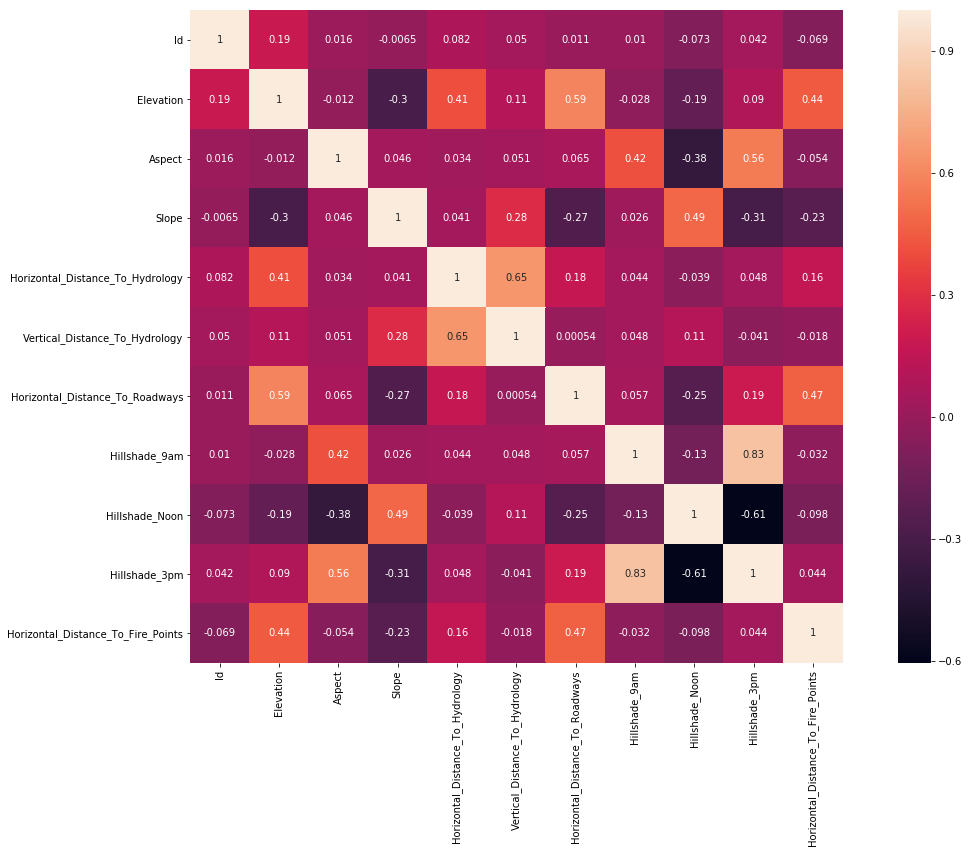

In [222]:
heat_col = ['Id', 'Elevation', 'Aspect', 'Slope',
 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']

cor_mat= train[heat_col].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(20,12)
sns.heatmap(data=cor_mat,square=True,annot=True,cbar=True)

- The Hillshades are highly correlated. Let's keep only one of them.
- The distances to Hydrology as well

In [8]:
def test_rem_feat(train):
    train = train.drop(['Id','Hillshade_9am','Hillshade_Noon','Horizontal_Distance_To_Hydrology'],axis=1)
    return train

In [224]:
train = test_rem_feat(train)

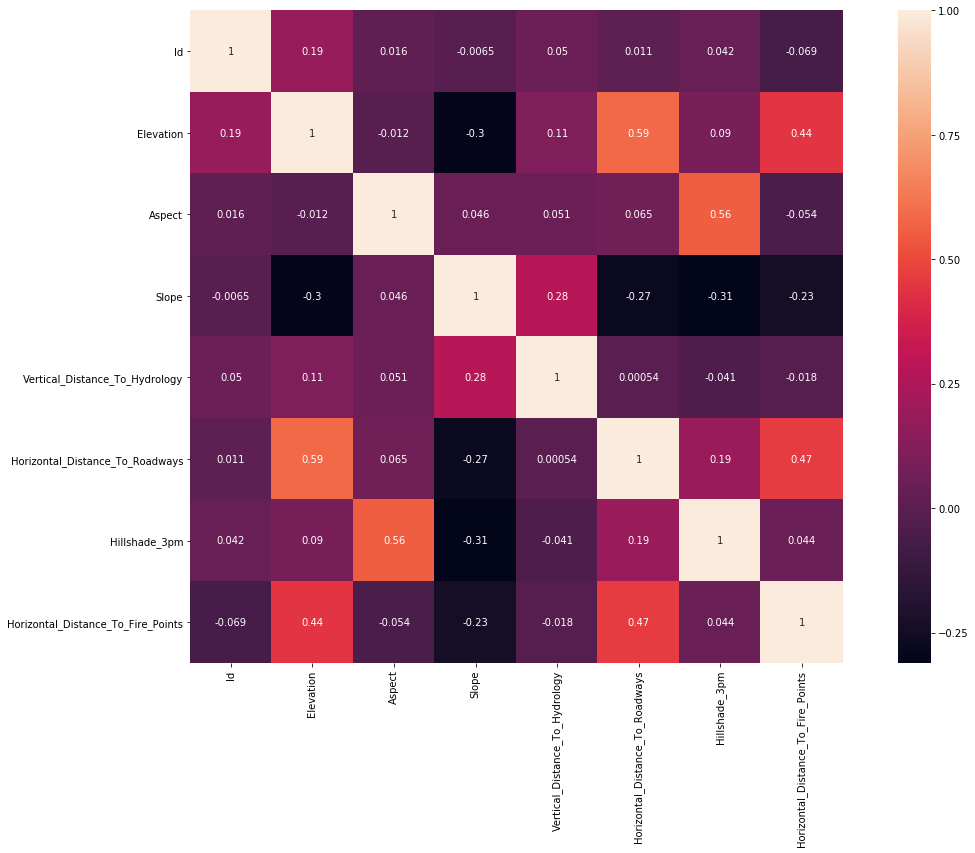

In [226]:
heat_col = ['Elevation', 'Aspect', 'Slope',
            'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways', 'Hillshade_3pm',
            'Horizontal_Distance_To_Fire_Points']

cor_mat= train[heat_col].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(20,12)
sns.heatmap(data=cor_mat,square=True,annot=True,cbar=True)

**One-hot-encoding**

It is already done.

**Data split for training**

In [9]:
def train_split(train):
    X = train.drop(['Cover_Type'],axis=1) 
    
    y = train['Cover_Type']
    y = y.astype('category')
    #y = pd.get_dummies(y)
    
    return X,y

In [264]:
X,y = train_split(train)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

## Modeling

In [266]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from progressbar import progressbar

models = [LogisticRegression(),RidgeClassifier(),RandomForestClassifier(),xgb.XGBClassifier()]
models_name = ['LR','Ridge','RandomForest','GradientBoost']
d = {}
score = []
acc = []

for i,model in progressbar(enumerate(models)):
    clf = model
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    score.append(clf.score(X_test,y_test))
    acc.append(accuracy_score(y_test,y_pred))
    
d = {'Model':models_name,'Score':score,'Accuracy':acc}
d = pd.DataFrame(d).sort_values(by='Score',ascending=False)
d

/ |#                                                  | 0 Elapsed Time: 0:00:00/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
- |       #                                           | 1 Elapsed Time: 0:00:00/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
| |                                                 # | 3 Elapsed Time: 0:00:15


,Model,Score,Accuracy
2,RandomForest,0.833885,0.833885
3,GradientBoost,0.761416,0.761416
0,LR,0.646592,0.646592
1,Ridge,0.626075,0.626075


Let's use RandomForest and tune it a bit. We use a 5-fold cross-validation.

In [267]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
'n_estimators': range(1,50),
'max_features': range(1,X_train.columns.size),
'max_depth': range(1,20),
'min_samples_split': range(2,20),
'min_samples_leaf':range(2,20),
}

my_forest = RandomForestClassifier()
my_forest_cv = RandomizedSearchCV(my_forest, param_dist, n_jobs=2,cv=5)
my_forest_cv = my_forest_cv.fit(X_train,y_train)

print("Score: ", my_forest_cv.score(X_test,y_test))
print("Accuracy: ", accuracy_score(y_test,my_forest_cv.predict(X_test)),'\n')
print("Best parameters: ", my_forest_cv.best_params_,'\n')

Score:  0.814361350099272
Accuracy:  0.814361350099272 

Best parameters:  {'n_estimators': 41, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 18, 'max_depth': 13} 



If we had time we would do the tuning manually using the accuracy against parameters:

In [294]:
acc_train=[]
acc_test = []
for i in progressbar(range(1,100,5)):
    rf = RandomForestClassifier(n_estimators=i)
    rf.fit(X_train,y_train)
    acc_train.append([i,accuracy_score(y_train,rf.predict(X_train))])    
    acc_test.append([i,accuracy_score(y_test,rf.predict(X_test))])

100% (20 of 20) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


Text(0.5, 1.0, 'Accuracy against n_estimator')

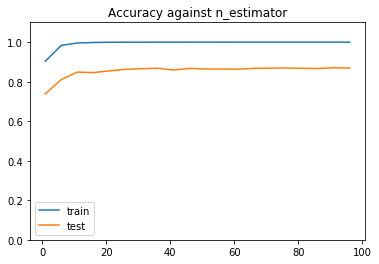

In [316]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
acc_train_np = np.array(acc_train)
acc_test_np = np.array(acc_test)
sns.lineplot(x=acc_train_np.T[0],y=acc_train_np.T[1],ax=ax1)
sns.lineplot(x=acc_test_np.T[0],y=acc_test_np.T[1],ax=ax1)
ax1.set_ylim([0,1.1])
ax1.legend(['train','test'])
ax1.set_title('Accuracy against n_estimator')

Let's look at the most influent features

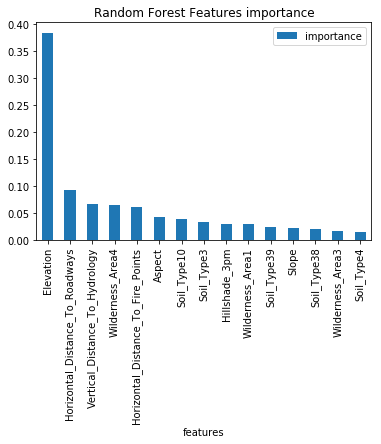

In [268]:
my_forest = my_forest_cv.best_estimator_

forest_viz = pd.DataFrame()
forest_viz['features'] = X_train.columns
forest_viz['importance'] = my_forest.feature_importances_
forest_viz = forest_viz.sort_values(by=['importance'],ascending=False)[:15]
forest_viz = forest_viz.set_index('features')
forest_viz.plot(kind='bar',title='Random Forest Features importance')

## Deep Learning

Baseline

In [55]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [56]:
from sklearn.preprocessing import LabelEncoder
from keras import utils

le = LabelEncoder()
le.fit(y)

y_enc = le.transform(y)
y_cat = utils.to_categorical(y_enc)

y_train_cat = utils.to_categorical(y_train_enc)
y_train_enc = le.transform(y_train)

y_test_cat = utils.to_categorical(y_test_enc)
y_test_enc = le.transform(y_test)

ValueError: y contains previously unseen labels: [3, 4, 5, 6, 7]

In [76]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline


# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)


# load dataset
dataframe = pandas.read_csv("iris.csv", header=None)
dataset = dataframe.values
X = dataset[:,0:4].astype(float)
Y = dataset[:,4]

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=4, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

results = cross_val_score(estimator, X, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Train on 108 samples, validate on 27 samples
Epoch 1/5
108/108 [==============================] - 5s 44ms/step - loss: 1.2601 - acc: 0.4167 - val_loss: 1.2507 - val_acc: 0.0000e+00
Epoch 2/5
108/108 [==============================] - 0s 169us/step - loss: 1.2386 - acc: 0.4167 - val_loss: 1.2481 - val_acc: 0.0000e+00
Epoch 3/5
108/108 [==============================] - 0s 137us/step - loss: 1.2172 - acc: 0.4167 - val_loss: 1.2482 - val_acc: 0.0000e+00
Epoch 4/5
108/108 [==============================] - 0s 146us/step - loss: 1.1988 - acc: 0.4167 - val_loss: 1.2465 - val_acc: 0.0000e+00
Epoch 5/5
15/15 [==============================] - 0s 130us/step
Train on 108 samples, validate on 27 samples
Epoch 1/5
108/108 [==============================] - 5s 45ms/step - loss: 2.2683 - acc: 0.4352 - val_loss: 3.2649 - val_acc: 0.0000e+00
Epoch 2/5
108/108 [==============================] - 0s 161us/step - loss: 2.2251 - acc: 0.4444 - val_loss: 3.1870 - val_acc: 0.0000e+00
Epoch 3/5
108/108 [======

In [26]:
model.predict(X_test)

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 3.1740191e-07, 0.0000000e+00, ..., 9.9999964e-01,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 9.9716020e-01, 0.0000000e+00, ..., 2.8397848e-03,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

## Prediction

We can now create the pipeline and submit an answer.

In [11]:
def train_pipeline(train):
    train = train_rem_outliers(train)
    train = test_edit_dist(train)
    train = test_rem_feat(train)
    X,y = train_split(train)
    return X,y

def test_pipeline(test):
    test = test_edit_dist(test)
    test = test_rem_feat(test)
    test[test['Vertical_Distance_To_Hydrology'].isna()]['Vertical_Distance_To_Hydrology'] = test['Vertical_Distance_To_Hydrology'].mean()
    return test

In [376]:
X = test_pipeline(test)
y_pred = my_forest.predict(X)
d = {'Id':test['Id'],'Cover_Type':y_pred}
d = pd.DataFrame(d)
d.to_csv('answer.csv',index=False)

In [14]:
X, y = train_pipeline(train)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta